In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST, EMNIST
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision.utils import save_image

transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

In [9]:
batch_size = 128
epochs = 30
latent_dim = 20

In [10]:
train_loader = torch.utils.data.DataLoader(
    FashionMNIST('../data', train=True, download=True,
                   transform=transform),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    FashionMNIST('../data', train=False, transform=transform),
    batch_size=batch_size, shuffle=True)

In [67]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        return mu, logvar
    
    def decode(self, z):
        return self.decoder(z)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim=784, hidden_dim=256, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [70]:
def loss_function(recon_x, x, mu, logvar, B):

  BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  KLD = -B * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + KLD

In [71]:
def train():
  model.train()
  train_loss = 0
  for i, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, logvar = model(data)
    loss = loss_function(recon_batch, data, mu, logvar, 4)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  
  return train_loss

In [72]:
def test():
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
      data = data.to(device)
      recon_batch, mu, logvar = model(data)
      test_loss += loss_function(recon_batch, data, mu, logvar, 4).item()

  return test_loss

Before Trainig


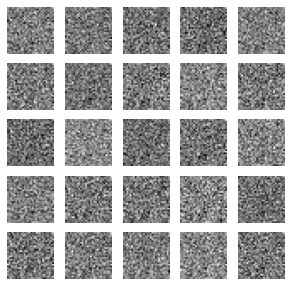

In [73]:
with torch.no_grad():
  print('Before Trainig')
  sample = torch.randn(64, 20).to(device)
  sample = model.decode(sample).cpu()
  fig = plt.figure(figsize=(5,5))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(sample[i].reshape(28,28),cmap='gray')
    plt.axis('off')
      
plt.show()

Epoch :  30 / 30


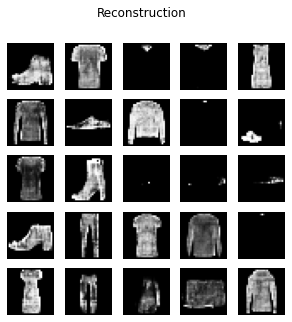

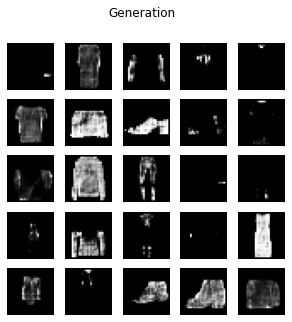

In [75]:
tar=[]
ter=[]

for e in range(epochs):
  tr=train()/len(train_loader.dataset)
  te=test()/len(test_loader.dataset)
  tar.append(tr)
  ter.append(te)
  display.clear_output(wait=True)
  print('Epoch : ',e+1,'/',epochs)

  with torch.no_grad():
    
    fig = plt.figure(figsize=(5,5))
    fig.suptitle('Reconstruction')
    for i in range(25):
      sample = model(train_loader.dataset[i][0].to(device))[0].cpu()
      plt.subplot(5,5, i+1)
      plt.imshow(sample.reshape(28,28),cmap='gray')
      plt.axis('off')

  plt.show()

  with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    sample = model.decode(sample).cpu()
    fig = plt.figure(figsize=(5,5))
    fig.suptitle('Generation')
    for i in range(25):
      plt.subplot(5,5, i+1)
      plt.imshow(sample[i].reshape(28,28),cmap='gray')
      plt.axis('off')

  plt.show()

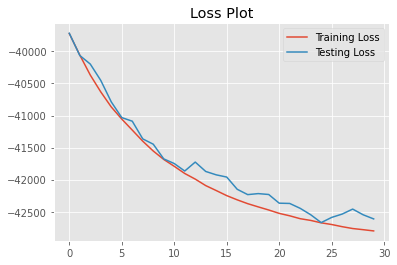

In [77]:
plt.style.use('ggplot')
plt.title('Loss Plot')
plt.plot(tar,label='Training Loss')
plt.plot(ter,label='Testing Loss')
plt.legend()
plt.show()

In [76]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt

In [78]:
N=700
lat=[]
labels=[]
for i in range(N):
  dat=train_loader.dataset[i][0]
  label=train_loader.dataset[i][1]
  ou=model.encode(dat.reshape(1,784).to(device))
  latent=model.reparameterize(ou[0],ou[1])
  lat.append(latent.cpu().detach().numpy())
  labels.append(label)

In [79]:
lat=np.array(lat)
lat=lat.reshape(N,20)

In [80]:
lat2 = TSNE(n_components=2).fit_transform(lat)

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1, figsize=(10,6))
cmap = plt.cm.tab20b
cmaplist = [cmap(i) for i in range(cmap.N)]
bounds = np.linspace(0,10,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
scat = ax.scatter(lat2[:,0],lat[:,1],c=labels,cmap=cmap,norm=norm)
cb = plt.colorbar(scat,ticks=[i for i in range(10)])
cb.set_label('Labels')
ax.set_title('TSNE plot for VAE Latent Space colour coded by Labels')
plt.show()